<a href="https://colab.research.google.com/github/Bulgun2/ChimidovaBA-SARS-CoV-2/blob/main/SAIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Таблица_2021-02-22_23-43.csv to Таблица_2021-02-22_23-43.csv


In [2]:
import pandas as pd
import io

covid_df = pd.read_csv(io.StringIO(uploaded['Таблица_2021-02-22_23-43.csv'].decode('utf-8')), sep = ';')
covid_df = covid_df.rename(columns = {'Дата': 'Date', 'Регион': 'Region', 'Заражений': 'Cum_confirmed', 'Выздоровлений': 'Cum_recovered',
                                     'Смертей': 'Cum_dead', 'Смертей за день': 'Deaths', 
                                      'Заражений за день': 'Confirmed', 'Выздоровлений за день': 'Recovered'}, inplace = False)

covid_df = covid_df[covid_df.Region.str.contains('Москва',case=False)]
covid_df['Date'] = pd.to_datetime(covid_df['Date'], format = '%d.%m.%Y')
covid_df = covid_df.sort_values(by='Date')
#covid_df['Date'] = covid_df['Date'].dt.strftime('%m/%d/%y')
covid_df.set_index('Date', inplace=True)
covid_df.head(5)

,Region,Cum_confirmed,Cum_recovered,Cum_dead,Deaths,Confirmed,Recovered
Date,,,,,,,
2020-03-12,Москва,21,0,0,0,21,0
2020-03-13,Москва,26,0,0,0,5,0
2020-03-14,Москва,35,0,0,0,9,0
2020-03-15,Москва,35,1,0,0,0,1
2020-03-16,Москва,53,1,0,0,18,0


Calculating coefficient combinations...
Finding errors in solutions...
----------------------------------------------------

SAIR WITH BETA AND GAMMA FITTED CONSIDERING ALL OBSERVATIONS

---PARAMETERS ESTIMATION---

Mean beta for Moscow: 0.44 
Estimated time of recovery (gamma): 10


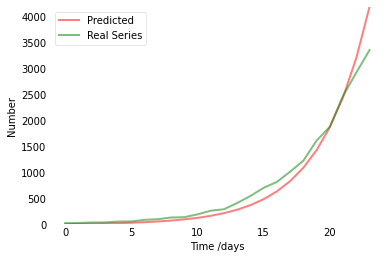

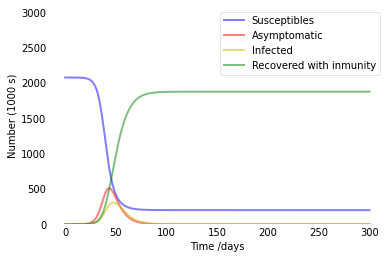


---INFECTION ANALYSIS---

Maximum number of infected will be: 308233.0 
Number of days from t(0): 48 / approx. date: 2020/04/29
Proportion of population infected at the maximum point: 14.83 %

---DURATION ESTIMATION---

Duration of the spread in days: 164 / approx. date: 2020/08/23 / time in month: 5.466666666666667

---HEALTH SYSTEM CAPACITY ANALYSIS---

Days until ICU is saturated: 27 / approx. date: 2020-04-08 
Days until Other beds saturated: Not reached / approx. date: Not reached

---TODAY'S PREDICTION---

Today's prediction for infected in Moscow (beta fitted to all observations): 5475.0
----------------------------------------------------

SIR WITH BETA AND GAMMA FITTED WITH THE LAST OBSERVATION

---PARAMETERS ESTIMATION---

Beta that better fits to the last infected observation: 0.39 
Estimated time of recovery (gamma): 13 
Error: 0.5


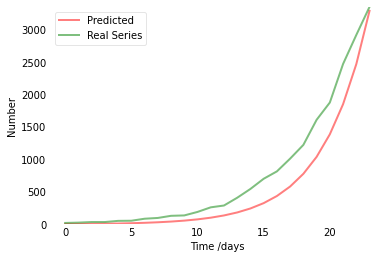

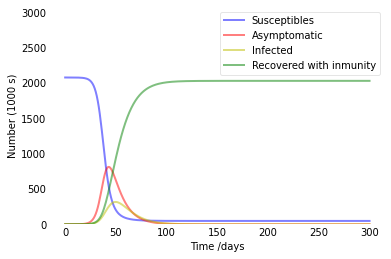

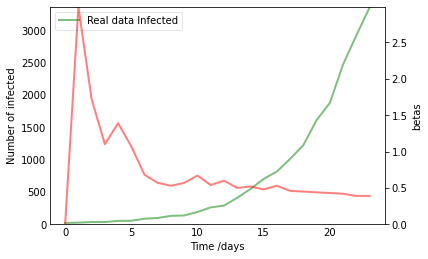


---INFECTION ANALYSIS---

Maximum number of infected will be: 316171.0 
Number of days from t(0): 50 / approx. date: 2020/05/01
Proportion of population infected at the maximum point: 15.21 %

---DURATION ESTIMATION---

Duration of the spread in days: 212 / approx. date: 2020/10/10 / time in month: 7.066666666666666

---HEALTH SYSTEM CAPACITY ANALYSIS---

Days until ICU saturated: 28 / approx. date: 2020-04-09 
Days until Other beds saturated: Not reached / approx. date: Not reached

---TODAY'S PREDICTION---

Today's prediction for infected in Moscow (beta fitted to last data): 4387.0


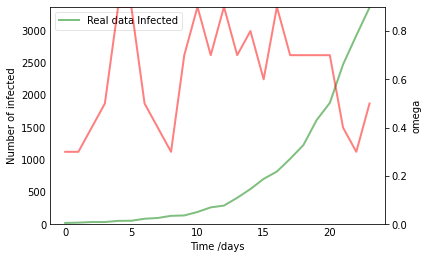

In [14]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from datetime import timedelta, datetime



########################SAIR MODEL#################################
def deriv(y, t, N, beta, gamma_i, gamma_e,omega):
    """
    SAIR model differential equations
    
    """
    S, A, I, R = y
    dSdt = -beta * S * A / N
    dAdt = beta * S * A / N - omega/gamma_i*A - (1-omega)/(gamma_i-gamma_e) * A
    dIdt = (1-omega)/(gamma_i-gamma_e) * A - 1/(gamma_i-gamma_e) * I
    dRdt = omega/gamma_i * A + 1/(gamma_i-gamma_e) * I
    return dSdt,dAdt,dIdt,dRdt



def findcoef(N,A0,I0,R0,stepB=0.1,maxB=1,stepG=1,maxG=14, stepO=0.1,minO=0.3,
             maxO=1,gamma_e=5 ,minG=1,days=160,verbose=False):
    """
    Finds all coefficient combinations (gamma and beta)
    Args: 
        -N: total population
        -I0: infected in the initial moment),
        -R0: recovered in the initial moment)
        -stepB: steps for Beta (default is 0.1)
        -stepG: steps for Gamma, in days (default is 1)
        -maxB: maximum beta allowed
        -maxG: maximum gamma allowed
        -days: maximum days in the simulation. 
        -verbose: if true, prints all tried combinations
        
    Returns: 
        -a list with all combinations. Each element in 
        the list contain beta, gamma and infected projection.
    """
    S0 = N - I0 - R0 -A0
    
    # Initial conditions vector
    y0 = S0, A0, I0, R0
    
    # A grid of time points (in days)
    t = np.linspace(0, days, days)
    
    #Initialize beta and gamma
    initB = stepB
    initG = minG
    initO=minO
    
    solutions = []
    
    if not verbose:
        print('Calculating coefficient combinations...')
    for O in np.arange(initO,maxO,stepO):
        for B in np.arange(initB,maxB,stepB):
            for G in np.arange(initG,maxG,stepG):
                if verbose:
                    print(B,G,O)
                solutions.append([])
                solutions[-1].append(B)
                solutions[-1].append(G)
                solutions[-1].append(O)
                ret = odeint(deriv, y0, t, args=(N, B, G ,gamma_e, O))
                S, A, I, R = ret.T
                
                solutions[-1].append(I)
            
    return solutions

def mqe(solutions,series,verbose=False):
    """
    Find coefficient with the least errors compared to the real data
    Args:
        -solutions: output of findcoef function
        -series: real data about the number of infected over the time
        -verbose: if true, prints all errors tried
    Returns:
        -List with the best solution [beta, gamma, error]
    """
    best = [0,0,0,10000]
    if not verbose:
        print('Finding errors in solutions...')
    for sol in solutions:

        inf_sol = sol[3][:len(series)]
        error = np.absolute((series-inf_sol))
        sq = sum(error)
        
        if verbose:
            print(sq)
            
        if sq < best[3]:
            best[0] = sol[0]
            best[1] = sol[1]
            best[2]= sol[2]
            best[3] = sq
            
    return best

def plot_curves(S,A,I,R,t,out=''):
    """
    Plots entire Infected, Suceptible and Recovered curve with predicted values
    Args:
        -I: Infected series projected
        -S: Suceptible series projected
        -R: Recovered series projected
        -t: Timeline
        -Out: name of the output plot file (if empty, no file saved)
    Returns: 
        - Plots entire Infected, Suceptible and Recovered curve with predicted values
    """
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, axisbelow=True)
    ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptibles')
    ax.plot(t, A/1000, 'r', alpha=0.5, lw=2, label='Asymptomatic')
    ax.plot(t, I/1000, 'y', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with inmunity')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000 s)')
    ax.set_ylim(0,N/1000 +1000)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    if out:
        plt.savefig(out)
    plt.show()


def plot_series(I,series,out=''):
    """
    Plot infected projection and real data
    Args:
        -I: Infected series projected
        -series: Real data series of Infected
        -Out: name of the output plot file (if empty, no file saved)
    Returns: Plot projection and real data
    """
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, axisbelow=True)
    ax.plot(range(len(series)), I[:len(series)], 'r', alpha=0.5, lw=2, label='Predicted')
    ax.plot(range(len(series)), series, 'g', alpha=0.5, lw=2, label='Real Series')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number')
    ax.set_ylim(0,max(max( I[:len(series)]),max(series)))
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    if out:
        plt.savefig(out)
    plt.show()
    
    
def best_betas(solutions,series):
    """
    Finds betas that reduce errors in predictions at each point of time
        -solutions: collection of all beta and gamma combinations (output 
                                                                 of find_coef)
        -series: real data serie of infected
  
    """
    betas = []
    
    for i in range(len(series)):
        best = [0,0,0,1000]
        for sol in solutions:
            if abs(series[i]-sol[3][i]) < best[3]:
                best[0] = sol[0]
                best[1] = sol[1]
                best[2] = sol[2]
                best[3] = abs(series[i]-sol[3][i])
        betas.append(best)
    return betas






def plot_betas(betas,series,out=''):
    """
    Plots betas over time and real series
    Args:
        -betas: estimated betas series
        -series: real data series of infected
        -out: name of the output plot file (if empty, no file saved)
    Returns: 
        - Plots betas over time and real series
    """
    betas_series = []
    for i in betas:
        betas_series.append(i[0])
    
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, axisbelow=True)    
    ax.plot(range(len(series)), series, 'g', alpha=0.5, lw=2, label='Real data Infected')
    ax2 = ax.twinx()
    ax2.plot(range(len(series)), betas_series, 'r', alpha=0.5, lw=2, label='beta')
    ax2.set_ylabel('betas')
    
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number of infected')
    ax.set_ylim(0,max(series)+10)
    ax2.set_ylim(0,max(betas_series))
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    if out:
        plt.savefig(out)
    plt.show()



def plot_omegas(betas,series,out=''):
    """
    Plots betas over time and real series
    Args:
        -betas: estimated betas series
        -series: real data series of infected
        -out: name of the output plot file (if empty, no file saved)
    Returns: 
        - Plots betas over time and real series
    """
    betas_series = []
    for i in betas:
        betas_series.append(i[2])
    
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, axisbelow=True)    
    ax.plot(range(len(series)), series, 'g', alpha=0.5, lw=2, label='Real data Infected')
    ax2 = ax.twinx()
    ax2.plot(range(len(series)), betas_series, 'r', alpha=0.5, lw=2, label='omega')
    ax2.set_ylabel('omega')
    
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number of infected')
    ax.set_ylim(0,max(series)+10)
    ax2.set_ylim(0,max(betas_series))
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    if out:
        plt.savefig(out)
    plt.show()


def max_inf(I,init_date):
    """
    Finds maximum number of infected, the day where this maximum is achieved
    and the aproximate date
    Args:
        -I: infected projected 
        -init_date: Date of first infection;
                initial date must be passed as string 'ddmmyyyy'
    Return:
        List with [max number of infected, days from t(0), approx. date yyyy/mm/dd]
    
    """
    date_obj=datetime.strptime(init_date,"%d%m%Y").date()
    max_date=date_obj+timedelta(days=int(np.argmax(I)))
    max_date=max_date.strftime("%Y/%m/%d")
    result=[max(I),np.argmax(I),max_date,round((max(I)/N)*100,2)]
    return result


def duration(I,init_date):
    """
    Finds the duration of the spread
    and the aproximate date
    Args:
        -I: infected projected
        -init_date: Date of first infection;
                initial date must be passed as string 'ddmmyyyy'
    Return:
        List with [ days from t(0), approx. date yyyy/mm/dd, time in months]
    
    """
    date_obj=datetime.strptime(init_date,"%d%m%Y").date()
    if len(np.argwhere(np.round(I,0)==0)) == 0:
        print("Series is too short and doesn't reach near-0 infected")
        return None
    else:
        max_date=date_obj+timedelta(days=int(np.argwhere(np.round(I,0)==0)[0]))
        max_date=max_date.strftime("%Y/%m/%d")
        result=[int(np.argwhere(np.round(I,0)==0)[0]),max_date, 
                int(np.argwhere(np.round(I,0)==0)[0])/30]
        return result
    
    
def health_sat(I,init_date,ICU,Other):
    """
    Calculates saturation points for healthcare systems depending
    on ICU beds and other (intermediate,etc) beds.
    
    Calculated according to WHO figures for the ammount of infected who
    will require ICU attention and other beds (6% and 14% respectively)
    
    Args:
        -I: infected projected
        -init_date: Date of first infection;
                initial date must be passed as string 'ddmmyyyy'
        -ICU: number of available ICU beds
        -Other: number of other available beds
    Return:
        List with [days until ICU is saturated, approx date, 
                   days until others is saturated, approx date]
        
        Note: if saturation is never reached for any of the elements,
        both fields will be 'Not reached'
    
    """
    
    
    date_obj=datetime.strptime(init_date,"%d%m%Y").date()
    ICU_needs=I*0.06
    Other_needs=I*0.14
    ICU_cap=ICU_needs-ICU
    Other_cap=Other_needs-Other
    if len(np.argwhere(np.round(ICU_cap,0)>=0)) == 0:
        days_ICU='Not reached'
        date_ICU='Not reached'
    else:
        days_ICU=int(np.argwhere(np.round(ICU_cap,0)>=0)[0])
        date_ICU=date_obj+timedelta(days=days_ICU)
    if len(np.argwhere(np.round(Other_cap,0)>=0)) == 0:
        days_Other='Not reached'
        date_Other='Not reached'
    else:
        days_Other=int(np.argwhere(np.round(Other_cap,0)>=0)[0])
        date_Other=date_obj+timedelta(days=days_Other)
    return [days_ICU, date_ICU, days_Other, date_Other]


## INPUTS##
# Total population, N.
N = 2078938
# Initial number of infected and recovered individuals, I0 and R0, E0.
I0, A0, R0  = 2,28,0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0- A0
#Moscow cases
moscow = np.array([  21,   26,   35,   35,   53,   55,   86,   98,  131,  137,  191,
        262,  290,  410,  546,  703,  817, 1014, 1226, 1613, 1880, 2475,
       2923, 3357])
init_date="12032020"
ICU=700
Other=54321
gamma_e=5

t = np.linspace(0,300,300)
y0 = S0,A0,I0,R0


sols = findcoef(N,A0,I0,R0,stepB=0.01,minG=10,gamma_e=gamma_e, maxB=3)
best = mqe(sols,moscow)


print('----------------------------------------------------\n')
print("SAIR WITH BETA AND GAMMA FITTED CONSIDERING ALL OBSERVATIONS\n")
print('---PARAMETERS ESTIMATION---\n')
print("Mean beta for Moscow:" , round(best[0],4) ,
      "\nEstimated time of recovery (gamma):", best[1])

#Create curve with found coefficients
beta = best[0]
gamma_i =best[1]
omega= best[2]

y0 = S0,A0,I0,R0
ret = odeint(deriv, y0, t, args=(N, beta,gamma_i,gamma_e, omega))
S, A, I, R = ret.T

S,A, I, R = ret.T

#plot series with real data and projection of infected
plot_series(I,moscow,'all_inf_v_real_SAIR')

#plot series of projection of I,S and R
plot_curves(S,A,I,R,t,'all_SAIR')

maxinf=max_inf(I,init_date)
print('\n---INFECTION ANALYSIS---\n')
print("Maximum number of infected will be:", round(maxinf[0],0) ,
      "\nNumber of days from t(0):", maxinf[1], "/ approx. date:", maxinf[2])
print("Proportion of population infected at the maximum point:", maxinf[3],'%')

dur = duration(I,init_date)
if dur:
    print('\n---DURATION ESTIMATION---\n')
    print("Duration of the spread in days:", dur[0], "/ approx. date:", 
          dur[1], "/ time in month:",dur[2])


health=health_sat(I,init_date,ICU,Other)
print('\n---HEALTH SYSTEM CAPACITY ANALYSIS---\n')
print("Days until ICU is saturated:", health[0], "/ approx. date:",  
      health[1], "\nDays until Other beds saturated:", health[2], "/ approx. date:",  
      health[3])


today_pred=I[len(moscow)]
print("\n---TODAY'S PREDICTION---\n")
print("Today's prediction for infected in Moscow (beta fitted to all observations):", 
      round(today_pred,0))

print('----------------------------------------------------\n')

###########SIR with beta and gamma that better fits to the last observation ###################### 
#########################################################################################
# best_betas return the most accurate beta, gamma and error for each point of time (minimizing the absolute error)


test = best_betas(sols,moscow)

print("SIR WITH BETA AND GAMMA FITTED WITH THE LAST OBSERVATION\n")
print('---PARAMETERS ESTIMATION---\n')
print("Beta that better fits to the last infected observation:", 
      round(test[-1][0],4), "\nEstimated time of recovery (gamma):",
      test[-1][1], "\nError:", round(test[-1][2],2))


#model prediction with last beta and gamma
beta = test[-1][0]
gamma_i = test[-1][1]
omega=test[-1][2]
y0 = S0, A0,I0, R0
gamma_e=5
ret = odeint(deriv, y0, t, args=(N, beta, gamma_i, gamma_e,omega))

S,A, I, R = ret.T  

#plot series with real data and projection of infected
plot_series(I,moscow,'last_inf_v_real_SAIR')

#plot series of projection of I,S and R
plot_curves(S,A,I,R,t,'last_SAIR')

plot_betas(test,moscow,'betas_SAIR')
today_pred=I[len(moscow)]



maxinf=max_inf(I,init_date)
print('\n---INFECTION ANALYSIS---\n')
print("Maximum number of infected will be:", round(maxinf[0],0) ,
      "\nNumber of days from t(0):", maxinf[1], "/ approx. date:", maxinf[2])
print("Proportion of population infected at the maximum point:", 
      round(maxinf[3],2),'%')

dur = duration(I,init_date)
if dur:
    print('\n---DURATION ESTIMATION---\n')
    print("Duration of the spread in days:", dur[0], "/ approx. date:", 
          dur[1], "/ time in month:",dur[2] )


health=health_sat(I,init_date,ICU,Other)
print('\n---HEALTH SYSTEM CAPACITY ANALYSIS---\n')
print("Days until ICU saturated:", health[0], "/ approx. date:",  
      health[1], "\nDays until Other beds saturated:", health[2], 
      "/ approx. date:",  health[3])

print("\n---TODAY'S PREDICTION---\n")
print("Today's prediction for infected in Moscow (beta fitted to last data):",
      round(today_pred,0))


plot_omegas(test, moscow)